<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем все нужные библиотеки и ознакомимся с датасетом

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Итак, в датасете 10 тысяч строк, в том числе 909 пропусов в столбце, отражающим продолжительно "жизни" клиента. Так же в датасете присутствуют столбцы, отражающие номер строки, id клиента и его фамилию. Совершенно очевидно, что эта информация не оказывает влияния на "отвал" клиента, поэтому от этих столбцов мы избавимся. Так же, проведем заполнение пропусков для правильной работы алгоритмов ML. Заодно, на всякий случай, проверим дубликаты.

In [4]:
data.duplicated().sum()

0

In [5]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
sorted(data['Tenure'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

In [7]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [8]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Пропуски заполнены, лишние столбцы для обучения модели удалены. В нашем датасете присутствуют два столбца типа object, которые нам предстоит преобразовать в числовые методом прямого кодирования, это столбцы Geography и Gender. Для начала посмотрим, сколько в них уникальных значений, чтобы представлять размеры нового датасета.

In [10]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

В сумме всего 5 уникальных значений, что говорит нам о том, что датасет увеличится всего лишь на одну колонку, ведь из 5 новых столбцов придется удалить по одному для каждого признака, чтоби избежать дамми-ловушки, а значит, что текущие 2 качественых столбца превратятся в 3 количественных.

In [12]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Мы устранили избыточное количество сильно зависимых столбцов для избежания дамми-ловушки, после преобразования качественных столбцов, но как насчет всего датафрейма? На всякий случай составим корреляционную матрицу для всего датасета

<AxesSubplot:>

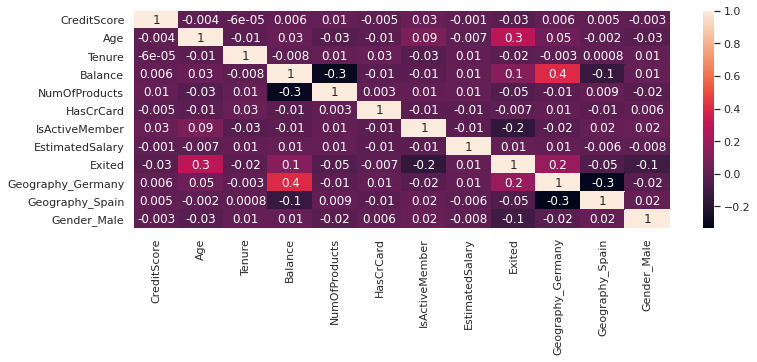

In [13]:
sns.set(rc = {'figure.figsize':(12,4)})
sns.heatmap(data_ohe.corr(), annot = True, fmt='.1g')

Тепловая карта не выявила корреляций между столбцами. Наибольший коэффициент зависимости (0.4) обнаружен между столбцом, отражающим принадлежность клиента к Германии и его балансом, что косвенно указывает на то, что клиенты из Германии в целом побогаче, но не более того, поэтому считать данные сильно зависимыми не стоит. Далее делим датафрейм на обучающую, валидационную и тестовую выборки, а потом каждую из них разделим соответственно на признаки и целевой признак.

In [14]:
train, valid, test = np.split(data_ohe, [int(0.6*len(data)), int(0.8*len(data))])

In [15]:
dataframe = [train, valid, test]
for element in dataframe:
    display(element.shape)

(6000, 12)

(2000, 12)

(2000, 12)

In [16]:
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']
features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']
features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

Датасеты с обучающими признаками нужно масштабировать. Для этого предварительно выделим все числовые столбцы.

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(data_ohe[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

In [18]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.086246,-1.225848,-0.911583,1,1,0.021886,0,0,0
1,-0.440036,0.198164,-1.448581,0.117350,-0.911583,0,1,0.216534,0,1,0
2,-1.536794,0.293517,1.087768,1.333053,2.527057,1,0,0.240687,0,0,0
3,0.501521,0.007457,-1.448581,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,0.388871,-1.086246,0.785728,-0.911583,1,1,-0.365276,0,1,0


In [19]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6000,-0.222754,-0.183251,1.812439,0.369591,2.527057,0,1,-1.303363,0,0,0
6001,1.287876,-0.850726,0.000761,-1.225848,-0.911583,1,0,1.630921,0,0,0
6002,0.522214,0.198164,-1.086246,-1.225848,-0.911583,1,0,-0.908288,0,0,0
6003,0.594642,-1.899615,0.725432,0.579059,-0.911583,1,1,-1.662362,0,1,1
6004,-1.340205,-1.613554,1.812439,-1.225848,-0.911583,1,1,0.021244,0,1,0


In [20]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8000,0.998166,-0.278604,1.087768,0.418587,0.807737,1,1,1.401612,1,0,1
8001,0.584295,-0.660018,1.450103,-1.225848,0.807737,1,0,0.458818,0,1,1
8002,-0.626278,-0.183251,-1.448581,-1.225848,0.807737,0,0,0.581588,0,1,1
8003,-0.491770,1.723821,0.363096,0.457012,0.807737,1,1,-0.220458,0,1,1
8004,-0.367609,0.579578,0.000761,-1.225848,0.807737,1,1,1.126745,0,0,1


Общие итоги:

- Проверили датасет на пропуски и дубликаты. Обработали пропуски, заполнив специальным значением -1
- Избавились от лишних столбцов, которые бесполезны для обучения модели
- Проверили корреляцию показателей, убеившись, что сильная зависимость отсутствует
- Преобразовали качественные данные методом прямого кодирования
- Провели масштабирование признаков 
- Разделили датасет на три выборки, выделив обучающие признаки и целевой признак

## Исследование задачи

После подготовки данных попробуем обучить несколько моделей и проверить их качество. На этом этапе мы не будем принимать во внимание дисбаланс классов. В качестве моделей будем использовать логистическую регрессию, решающее дерево и случайный лес. В этом блоке мы намеренно игнорируем дисбаланс, чтобы понять, как его устранени повлияет на качество модели, но для общего понимания сразу же посчитаем его.

In [21]:
data_ohe['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [22]:
train['Exited'].value_counts()

0    4751
1    1249
Name: Exited, dtype: int64

Соотношение между "отвалившимися" и оставшимися клиентами составляет приблизительно 1/4, что говорит о серьезном дисбалансе значений. Далее перейдем к моделям.

In [23]:
%%time
# Логистическая регрессия 

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)

print('F1-мера составила:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

F1-мера составила: 0.3881118881118881
AUC-ROC: 0.7691092792301081
CPU times: user 40.3 ms, sys: 19.5 ms, total: 59.8 ms
Wall time: 22.4 ms


In [24]:
%%time
# Решающее дерево

best_f1_result = 0
best_tree_depth = 0
best_model = None
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_tree_depth = depth
        best_f1_result = F1
        best_model = model

print('Глубина лучшей модели:', best_tree_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Глубина лучшей модели: 5
F1 лучшей модели: 0.6095791001451378
AUC-ROC лучшей модели: 0.8471257661591353
CPU times: user 478 ms, sys: 19.2 ms, total: 498 ms
Wall time: 556 ms


In [25]:
%%time
#Случайный лес

best_f1_result = 0
best_tree_depth = 0
best_estimators = 0
best_model = None
for est in range(1, 101):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_estimators = est
        best_f1_result = F1
        best_model = model
    
for depth in range(1, 21):
    model = model = RandomForestClassifier(random_state=12345, n_estimators=best_estimators, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_depth = depth
        best_f1_result = F1
        best_model = model

print('Количество деревьев лучшей модели:', best_estimators)
print('Глубина лучшей модели:', best_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Количество деревьев лучшей модели: 47
Глубина лучшей модели: 15
F1 лучшей модели: 0.6170212765957447
AUC-ROC лучшей модели: 0.8548163727501428
CPU times: user 38.5 s, sys: 325 ms, total: 38.9 s
Wall time: 38.9 s


Наилучший результат показала модель Случайный лес с 75 деревьями и глубиной 19, значения для F1 и AUC-ROC составили соответственно 0.61 и 0.85. Мы не работали с дисбалансом классов, а значит следует проверить, изменятся ли наши показатели при его устранении. Прежде чем проводить исследование с устраненным дисбалансом, попробуем повторить обучение моделей, но с учетом веса классов в моделях

In [26]:
%%time
# Логистическая регрессия 

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)

print('F1-мера составила:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

F1-мера составила: 0.4796380090497738
AUC-ROC: 0.7736309512606728
CPU times: user 16.4 ms, sys: 51.5 ms, total: 67.9 ms
Wall time: 35.3 ms


In [27]:
%%time
# Решающее дерево

best_f1_result = 0
best_tree_depth = 0
best_model = None
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_tree_depth = depth
        best_f1_result = F1
        best_model = model

print('Глубина лучшей модели:', best_tree_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Глубина лучшей модели: 6
F1 лучшей модели: 0.573385518590998
AUC-ROC лучшей модели: 0.8412811560925726
CPU times: user 484 ms, sys: 31.6 ms, total: 515 ms
Wall time: 559 ms


In [28]:
%%time
#Случайный лес

best_f1_result = 0
best_tree_depth = 0
best_estimators = 0
best_model = None
for est in range(1, 101):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_estimators = est
        best_f1_result = F1
        best_model = model
    
for depth in range(1, 21):
    model = model = RandomForestClassifier(random_state=12345, n_estimators=best_estimators, max_depth=depth, 
                                           class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_depth = depth
        best_f1_result = F1
        best_model = model

print('Количество деревьев лучшей модели:', best_estimators)
print('Глубина лучшей модели:', best_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Количество деревьев лучшей модели: 55
Глубина лучшей модели: 9
F1 лучшей модели: 0.6221692491060787
AUC-ROC лучшей модели: 0.8639028475711892
CPU times: user 39.9 s, sys: 201 ms, total: 40.1 s
Wall time: 40.2 s


Итак, что мы получаем? Лучший результат у случайного леса. И этот результат улучшается при соблюдении принципа учета веса классов. Значения F1 и AUC-ROC составили 0.63 и 0.86 соответственно. 

## Борьба с дисбалансом

Как мы выяснили в разделе 2, на одно значение "1" приходится четыре значения "0", что говорит нам о необходимости устранения дисбаланса. 

Сначала попробуем метод увеличения выборки

In [29]:
def upsample(features, target, repeat):
    features_ones = features[target == 1]
    features_zeros = features[target == 0]
    target_ones = target[target == 1]
    target_zeros = target[target == 0]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [30]:
print(features_train.shape)
print(target_train.shape)
print(features_upsampled.shape)
print(target_upsampled.shape)

(6000, 11)
(6000,)
(9747, 11)
(9747,)


Проверим снова все модели, но уже с учетом проведенной работы по устранению дисбаланса 

In [31]:
%%time
# Логистическая регрессия 

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)

print('F1-мера составила:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

F1-мера составила: 0.47585601404741007
AUC-ROC: 0.7737705380836769
CPU times: user 25.8 ms, sys: 51.6 ms, total: 77.4 ms
Wall time: 51.4 ms


In [32]:
%%time
# Решающее дерево

best_f1_result = 0
best_tree_depth = 0
best_model = None
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_tree_depth = depth
        best_f1_result = F1
        best_model = model

print('Глубина лучшей модели:', best_tree_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Глубина лучшей модели: 6
F1 лучшей модели: 0.577560975609756
AUC-ROC лучшей модели: 0.8486063275177385
CPU times: user 577 ms, sys: 43.8 ms, total: 621 ms
Wall time: 644 ms


In [33]:
%%time
#Случайный лес

best_f1_result = 0
best_tree_depth = 0
best_estimators = 0
best_model = None
for est in range(1, 101):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_estimators = est
        best_f1_result = F1
        best_model = model
    
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=12345, n_estimators=best_estimators, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_depth = depth
        best_f1_result = F1
        best_model = model

print('Количество деревьев лучшей модели:', best_estimators)
print('Глубина лучшей модели:', best_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Количество деревьев лучшей модели: 86
Глубина лучшей модели: 9
F1 лучшей модели: 0.6268656716417911
AUC-ROC лучшей модели: 0.8541474538736128
CPU times: user 59 s, sys: 157 ms, total: 59.2 s
Wall time: 59.2 s


Попробуем другой способ и снова проверим модели. 

In [34]:
def downsample(features, target, fraction):
    features_ones = features[target == 1]
    features_zeros = features[target == 0]
    target_ones = target[target == 1]
    target_zeros = target[target == 0]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state = 12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state = 12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = 12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.26)

In [35]:
print(features_train.shape)
print(target_train.shape)
print(features_downsampled.shape)
print(target_downsampled.shape)

(6000, 11)
(6000,)
(2484, 11)
(2484,)


In [36]:
%%time
# Логистическая регрессия 

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)

print('F1-мера составила:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

F1-мера составила: 0.4861483467381591
AUC-ROC: 0.7744684721986963
CPU times: user 17.9 ms, sys: 51.7 ms, total: 69.5 ms
Wall time: 42.4 ms


In [37]:
%%time
# Решающее дерево

best_f1_result = 0
best_tree_depth = 0
best_model = None
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_tree_depth = depth
        best_f1_result = F1
        best_model = model

print('Глубина лучшей модели:', best_tree_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Глубина лучшей модели: 5
F1 лучшей модели: 0.5593561368209256
AUC-ROC лучшей модели: 0.8390799189455392
CPU times: user 267 ms, sys: 63.2 ms, total: 331 ms
Wall time: 340 ms


In [38]:
%%time
#Случайный лес

best_f1_result = 0
best_tree_depth = 0
best_estimators = 0
best_model = None
for est in range(1, 101):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_estimators = est
        best_f1_result = F1
        best_model = model
    
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=12345, n_estimators=best_estimators, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    F1 = f1_score(target_valid, predicted_valid)
    if F1 > best_f1_result:
        best_depth = depth
        best_f1_result = F1
        best_model = model

print('Количество деревьев лучшей модели:', best_estimators)
print('Глубина лучшей модели:', best_depth)
print('F1 лучшей модели:', best_f1_result)
probabilities_valid = best_model.predict_proba(features_valid)
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_valid[:, 1]))

Количество деревьев лучшей модели: 68
Глубина лучшей модели: 8
F1 лучшей модели: 0.6
AUC-ROC лучшей модели: 0.8618513917904128
CPU times: user 22.4 s, sys: 128 ms, total: 22.5 s
Wall time: 22.5 s


Общий вывод:
Итак, на мой взгляд, лучшей моделью показал себя случайный лес с количеством деревьев 86 и глубиной 8, с устранением дисбаланса методом увеличения выборки, соответствующие значения F1 и AUC-ROC составили 0.625 и 0.855

## Тестирование модели

In [39]:
features_list = [features_train, features_valid]
features = pd.concat(features_list)

target_list = [target_train, target_valid]
target = pd.concat(target_list)

model = RandomForestClassifier(random_state=12345, n_estimators=86, max_depth=8, class_weight='balanced')
model.fit(features, target)
predicted_test = model.predict(features_test)
print("F1 на тестовой выборке:", f1_score(target_test, predicted_test))
probabilities_test = model.predict_proba(features_test)
print("AUC-ROC на тестовой выборке:", roc_auc_score(target_test, probabilities_test[:, 1]))

F1 на тестовой выборке: 0.6039952996474736
AUC-ROC на тестовой выборке: 0.8522615066093328


Итог:
После применения выбранной модели метрика F1 на тестовой выборке оказалась даже лучше, чем на валидационной, AUC-ROC снизилась незначительно, и составила 0.852

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*